### TODO:
- Put correlation between apps? Useful?

### Done/dismissed but recorded:
- Try demeaning all series? - doesn't work well.
- Why do plots have such different proportions of houses? - because three homes have data for *all* time periods.
- Changed kettle on_power_threshold to 1500 (from 2000) since it wasn't catching activations for house 3.
- Figure out why house 3/5/20 has inverse fridge pattern. - not sure but can look into it later
- Bayesian opt for hyperparameter selection - would take too much time and needs to be done all at once (as opposed to random search)
- Visualize activations.
- Look at LBM paper for error. (???)
- Look at where model is getting things wrong. Make function that plots largest/pathological errors.
- Add x=y line to predictions vs. actual. - Just set xlim and ylim equal and tried to make plots square

In [1]:
from __future__ import division

from utils import *
from create_data import *
from build_models import *

import os
import sys
import pandas as pd
import numpy as np
from collections import OrderedDict
import time
from datetime import datetime, date, timedelta
from dateutil.parser import parse
import re
from decimal import Decimal
import warnings

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import keras
from keras import backend as K
from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint, LambdaCallback
from keras.utils import plot_model
from keras import regularizers

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
dir_proj = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dissertation/thesis'
dir_data = os.path.join(dir_proj, 'data')
dir_for_model = os.path.join(dir_data, 'for_model')
dir_for_model_real = os.path.join(dir_for_model, 'real')
dir_for_model_synth = os.path.join(dir_for_model, 'synthetic')
dir_models = os.path.join(dir_data, 'models')
dir_run = os.path.join(dir_proj, 'run', str(date.today()))
path_daily_stats = os.path.join(dir_data, 'stats_by_day.pkl')

In [3]:
# N_PER_DAY = 14400  # 24 * 60 * 60 / 6
# HOUSE_IDS, HOUSE_IDS_TEST_UNSEEN, HOUSE_IDS_NOT_TEST_UNSEEN, HOUSE_IDS_SOLAR = get_house_id_groups()
# HOUSE_IDS_NOT_SOLAR = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_SOLAR]
# # TRAIN_VAL_DATE_MAX = date(2015,2,28)
# APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
# TRAIN_DTS = np.load(os.path.join(dir_for_model_synth, 'train_dts.npy'))
# TARGET_TYPES = ['energy', 'activations']

N_PER_DAY = 14400  # 24 * 60 * 60 / 6
HOUSE_IDS, HOUSE_IDS_SEEN, HOUSE_IDS_VAL_UNSEEN, HOUSE_IDS_TEST_UNSEEN, HOUSE_IDS_SOLAR = get_house_id_groups()
HOUSE_IDS_NOT_SOLAR = [house_id for house_id in HOUSE_IDS if house_id not in HOUSE_IDS_SOLAR]
# TRAIN_VAL_DATE_MAX = date(2015,2,28)
APP_NAMES = ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
TRAIN_DTS = np.load(os.path.join(dir_for_model_synth, 'train_dts.npy'))
TARGET_TYPES = ['energy', 'activations']

In [4]:
take_diff = False
# val_prop = 0.2
train_dates = [dt.date() for dt in TRAIN_DTS]
extreme_percentile_cutoff = 100

In [5]:
np.random.seed(20170627)

dstats = pd.read_pickle(path_daily_stats)
dstats = clean_daily_stats(dstats, is_debug=False)

all_data = prepare_real_data(dir_for_model_real,
                             dstats,
                             HOUSE_IDS_SOLAR,
                             HOUSE_IDS_SEEN,
                             HOUSE_IDS_VAL_UNSEEN,
                             HOUSE_IDS_TEST_UNSEEN,
                             train_dates)

all_data = prepare_synth_data(dir_for_model_synth,
                              all_data = all_data)
show_data_dims(all_data, train_dates)
# del all_data['val_seen'], all_data['val_unseen']

# Want to take diffs before making scalers.
if take_diff:
    print 'taking diffs...'
    for key, dat in all_data.iteritems():
        all_data[key]['X'] = take_diff_df(dat['X'])

print 'creating scalers...'
scaler_real, scaler_synth, scaler_both = create_scalers(all_data)

print 'scaling validation and test data...'
for split_type in ['val', 'test_seen', 'test_unseen']:
    all_data[split_type]['X'] = scaler_real.transform(all_data[split_type]['X'])
    all_data[split_type]['X'] = scaler_both.transform(all_data[split_type]['X'])

processing real data...
removing homes with solar panels...
removing obs where correlation between main and sum of apps is low...
removed 15 obs (0.21% of total)
removing obs where agg value is repeated...
removed 86 obs (1.2% of total)
splitting into training, val/test (seen), val (unseen), and test (unseen)...
-----
0.450845514474 training
0.0983089710519 val, seen
0.166093436515 val, unseen
0.0983089710519 test, seen
0.186443106907 test, unseen
-----
splitting val/test (seen) into val and test (seen)...
combining val (seen) and val (unseen) into val
loading synthetic data...
val_seen <type 'dict'>
    Y1: (686, 5)
    X: (686, 14400)
    Y2: (686, 5)
    x_date: (686,)
    x_house: (686,)
    houses: [4, 6, 7, 8, 10, 12, 13, 16, 17, 18, 19]
    missing houses: [1, 2, 3, 5, 9, 11, 15, 20, 21]
    num. unique days: 156
    has training dates: False
    has non-training dates: True

val <type 'dict'>
    Y1: (1845, 5)
    X: (1845, 14400)
    Y2: (1845, 5)
    x_date: (1845,)
    x_hou

/Users/sipola/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


scaling validation and test data...


In [73]:
# Synth augmentation factor.
(39800 + 3146) / 3146

13.650985378258106

In [6]:
dir_refit_csv = os.path.join(dir_data, 'CLEAN_REFIT_081116')
dir_refit = os.path.join(dir_data, 'refit')

apps = pd.read_csv(os.path.join(dir_data, 'appliances.csv'))
app_dict = create_app_dict()
apps = apps_add_cols_from_patterns(apps, app_dict)

get_house_app_tuples, get_app_nums, get_app_name, is_a_target_app, get_standardized_app_names = create_app_funs(apps, app_dict, APP_NAMES)
load_app, load_ts, load_issues = create_load_funs(dir_refit)

In [84]:
# def app_names_to_plot_name(app_names):
#     return app_names[0] if app_names != APP_NAMES else 'all'

# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111)

# # matplotlib.cm.plasma((colors-np.min(colors))/(np.max(colors)-np.min(colors)))
# apps_to_plot = [[app_name] for app_name in APP_NAMES] + [APP_NAMES]
# # color_idx = np.linspace(0, 1, len(apps_to_plot))
# color_idx = range(len(apps_to_plot))
# # cm = plt.cm.Set1
# cm = plt.cm.tab10

# all_random_curves = []
# modeling_group_name = 'main'
# for apps_color_idx, app_names in enumerate(apps_to_plot):
#     for target_type in ['energy', 'activations']:
#         linestyle = '-' if target_type=='energy' else '--'
#         dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
#         hist_and_params = get_histories_df(dir_models_set).reset_index()
#         hist_and_params['model'] = hist_and_params['model'].str.replace('model_', '').apply(pd.to_numeric)
#         hist_and_params.sort_values('model', inplace=True)
#         # print app_names_to_filename(app_names), hist_and_params.shape
#         all_random_curves_one = pd.DataFrame.from_dict({
#             'target_type': target_type,
#             'app_names': app_names_to_plot_name(app_names),
#             'model': hist_and_params['model'],
#             'val_loss': cummin(hist_and_params['val_loss'])
#         })
#         # print all_random_curves_one
#         plot_args = {
#             'x': 'model',
#             'y': 'val_loss',
#             'kind': 'line',
#             'drawstyle': 'steps-pre',
#             'color': cm(color_idx[apps_color_idx]),
#             'linestyle': linestyle,
#             'label': '{} - {}'.format(app_names_to_plot_name(app_names), target_type)
#         }
#         all_random_curves_one.plot(ax=ax, **plot_args)
#         all_random_curves.append(all_random_curves_one)
# plt.ylabel('Best validation error')
# plt.xlabel('Model run')
# plt.title('Best validation error for all models up to model run')
# all_random_curves = pd.concat(all_random_curves)
# # plt.savefig(os.path.join(dir_run, 'random_search_best_val_error.pdf'))

In [7]:
def app_names_to_plot_name(app_names):
    if isinstance(app_names, basestring):
        return app_names
    elif len(app_names)==1:
        return app_names[0]
    elif app_names == APP_NAMES:
        return 'all target appliances'
    else:
        return ', '.join(app_names)

total number of models: 300


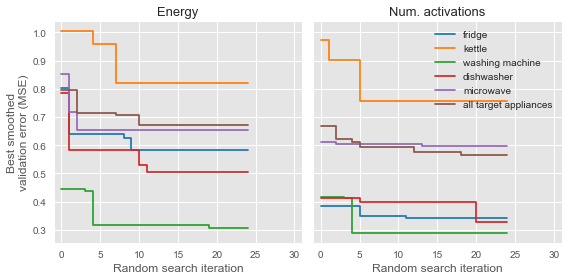

In [394]:
# Plot best validation errors.
# Two try statements below are for catching cases where folders don't exist.

figsize = (8,4)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=figsize)

apps_to_plot = [[a] for a in APP_NAMES] + [APP_NAMES]
# color_idx = np.linspace(0, 1, len(apps_to_plot))
color_idx = range(len(apps_to_plot))
cm = plt.cm.tab10

all_random_curves = []
modeling_group_name = 'main'
for plot_idx, target_type in enumerate(['energy', 'activations']):
    ax = axes[plot_idx]
    for apps_color_idx, app_names in enumerate(apps_to_plot):
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        try:
            hist_and_params = get_histories_df(dir_models_set).reset_index()
        except OSError:
            continue
        hist_and_params['model'] = hist_and_params['model'].str.replace('model_', '').apply(pd.to_numeric)
        hist_and_params.sort_values('model', inplace=True)
        # print app_names_to_filename(app_names), hist_and_params.shape
        all_random_curves_one = pd.DataFrame.from_dict({
            'target_type': target_type,
            'app_names': app_names_to_plot_name(app_names),
            'model': hist_and_params['model'],
            'val_loss': cummin(hist_and_params['val_loss'])
        })
        plot_args = {
            'x': 'model',
            'y': 'val_loss',
            'kind': 'line',
            'drawstyle': 'steps-post',
            'color': cm(color_idx[apps_color_idx]),
            'label': '{}'.format(app_names_to_plot_name(app_names))
        }
        ax = all_random_curves_one.plot(ax=ax, **plot_args)
        all_random_curves.append(all_random_curves_one)
        
    ax.set_title((target_type if target_type=='energy' else 'num. activations').capitalize(), size=13)
    ax.set_ylabel('Best smoothed\nvalidation error (MSE)')
    ax.set_xlabel('Random search iteration')
    ax.set_xlim((-1, 31))
    if plot_idx == 0:
        try:
            ax.legend().set_visible(False)
        except AttributeError:
            pass

fig.tight_layout()
# plt.suptitle('Best validation error in random search', size=16)
# fig.subplots_adjust(top=0.87)  # NEED THIS?!!!!!!!!!!??????!?!??!??!?!?!?!??!??!!?!?!?!?!
all_random_curves = pd.concat(all_random_curves)
makedirs2(dir_run)
plt.savefig(os.path.join(dir_run, 'random_search_best_val_error.pdf'))

print 'total number of models: {}'.format(all_random_curves.shape[0])

In [55]:
# For example model
create_model(
    1,
    N_PER_DAY,
    num_conv_layers = 5,
    num_dense_layers = 2,
    start_filters = 4,
    deepen_filters = True,
    kernel_size = 3,
    strides = 1,
    dilation_rate = 1,
    do_pool = True,
    pool_size = 2,
    last_dense_layer_size = 16,
    dropout_rate_after_conv = 0.5,
    dropout_rate_after_dense = 0.25,
    use_batch_norm = False,
    optimizer = keras.optimizers.Adam,
    learning_rate = 0.001,
    l2_penalty = 0.0000001,
    hidden_layer_activation = 'relu',
    output_layer_activation = 'relu',
    loss = 'mse'
).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 14400, 4)          16        
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 7200, 4)           0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 7200, 8)           104       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 3600, 8)           0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 3600, 16)          400       
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 1800, 16)          0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 1800, 32)          1568      
__________

In [395]:
# Create data to for LaTeX table describing architectures.

# modeling_group_name = 'main_2017-07-28'
modeling_group_name = 'main'

app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]

num_params_name = 'number of parameters'
randomized_params = [
    'num_conv_layers',
    'num_dense_layers',
    'start_filters',
    'kernel_size',
    'strides',
    'pool_size',
    'last_dense_layer_size',
    'learning_rate',
    'l2_penalty',
    num_params_name
]

params_df = []
for target_type in TARGET_TYPES:
    print target_type
    for app_names in app_names_list:
        print '    {}'.format(app_names)
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        params_this = pickle.load(open(os.path.join(dir_models_set, model_name, 'params.pkl'), 'rb'))
        params_this[num_params_name] = load_best_model(dir_models_set).count_params()  # takes a while
        params_df_this = pd.DataFrame.from_dict(params_this, orient='index').reset_index()
        params_df_this.columns = ['param', 'value']
        params_df_this['app_name'] = app_names_to_plot_name(app_names)
        params_df_this['target_type'] = target_type
        params_df.append(params_df_this)
        
params_df = pd.concat(params_df)
params_df = params_df.reset_index().drop('index', axis=1)  # resets numbering of index
params_df = params_df.loc[params_df['param'].isin(randomized_params)]

params_df.set_index(['app_name', 'target_type'], inplace=True)  # for pivot
params_df = params_df.pivot(columns='param')  # set to wide
params_df.columns = params_df.columns.droplevel()
params_df = params_df[randomized_params]  # reorder columns so most important are first

energy
    ['fridge']
    ['kettle']
    ['washing machine']
    ['dishwasher']
    ['microwave']
    ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']
activations
    ['fridge']
    ['kettle']
    ['washing machine']
    ['dishwasher']
    ['microwave']
    ['fridge', 'kettle', 'washing machine', 'dishwasher', 'microwave']


In [398]:
# Create LaTeX table with hyperparams.

for target_type in TARGET_TYPES:

    params_target = params_df.drop(labels=target_type, level=1, axis=0)
    params_target.index = params_target.index.droplevel(1)
    params_target = params_target.reindex(APP_NAMES + [app_names_to_plot_name(APP_NAMES)])

    # Need this in latex document: \newcommand*\rot{\rotatebox{90}}
    t = []
    t.append('\\begin{center}')
    t.append('\\begin{tabular}{' + ' l | ' + 'c '*(params_target.shape[1]-1) + '|c' + '}')
    rotated_cols = ['\\rot{\\texttt{' + v + '}}' if v!=num_params_name else '\\rot{'+v+'}' for v in params_target.columns.values]
    t.append(' & ' + ' & '.join(rotated_cols) + ' \\\\')
    t.append('\\hline')
    for i, row in enumerate(params_target.iterrows()):
        param_name = params_target.index.values[i]
        row_pretty = ['{:0.2g}'.format(v) if v >= 1 else '{:0.1e}'.format(Decimal(v)) for v in row[1].values]
        row_pretty = [param_name] + row_pretty
        t.append(' & '.join(row_pretty) + ' \\\\')
    t.append('\\end{tabular}')
    t.append('\\end{center}')
    
    print '\n'
    print target_type
    print '\n'
    print '\n'.join(t)



energy


\begin{center}
\begin{tabular}{ l | c c c c c c c c c |c}
 & \rot{\texttt{num_conv_layers}} & \rot{\texttt{num_dense_layers}} & \rot{\texttt{start_filters}} & \rot{\texttt{kernel_size}} & \rot{\texttt{strides}} & \rot{\texttt{pool_size}} & \rot{\texttt{last_dense_layer_size}} & \rot{\texttt{learning_rate}} & \rot{\texttt{l2_penalty}} & \rot{number of parameters} \\
\hline
fridge & 7 & 1 & 4 & 5 & 1 & 3 & 13 & 1.6e-3 & 1.0e-8 & 2.4e+05 \\
kettle & 6 & 2 & 4 & 6 & 1 & 4 & 9 & 2.4e-3 & 2.7e-7 & 7.5e+04 \\
washing machine & 7 & 1 & 7 & 4 & 1 & 3 & 23 & 1.2e-3 & 0.0e+1 & 6.1e+05 \\
dishwasher & 7 & 2 & 6 & 3 & 1 & 3 & 17 & 4.4e-4 & 6.2e-7 & 3.9e+05 \\
microwave & 5 & 2 & 6 & 3 & 1 & 4 & 26 & 2.8e-3 & 7.2e-8 & 9.5e+04 \\
all target appliances & 5 & 2 & 5 & 3 & 1 & 4 & 26 & 2.1e-3 & 3.7e-8 & 7.7e+04 \\
\end{tabular}
\end{center}


activations


\begin{center}
\begin{tabular}{ l | c c c c c c c c c |c}
 & \rot{\texttt{num_conv_layers}} & \rot{\texttt{num_dense_layers}} & \rot{\textt

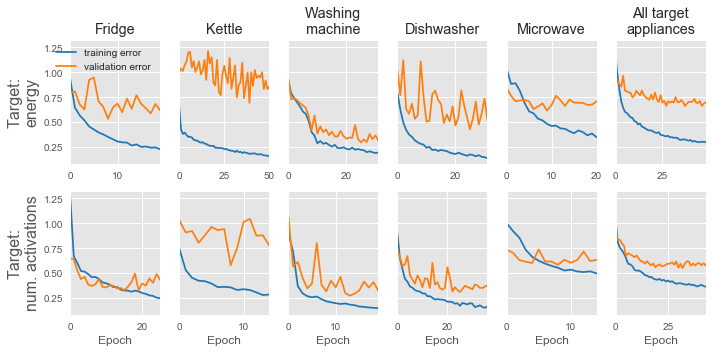

In [399]:
# Create error curves.

cm = plt.cm.tab10

modeling_group_name = 'main'

# for modeling_group_name in ['main', 'more_patience']:

app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]

fig = plt.figure(figsize=(10,5))
gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=len(app_names_list))
        
histories = []
plot_num = 0
for target_type in TARGET_TYPES:
    # print target_type
    for app_names in app_names_list:
        # print '    {}'.format(app_names)
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        history = pd.DataFrame.from_csv(os.path.join(dir_models_set, model_name, 'history.csv'))

        if plot_num==0:
            ax = fig.add_subplot(gs[plot_num])
        else:
            # ax = fig.add_subplot(gs[plot_num], sharey=ax, sharex=ax)
            # ax = fig.add_subplot(gs[plot_num])
            ax = fig.add_subplot(gs[plot_num], sharey=ax)

        history.rename(columns={'loss': 'training error', 'val_loss': 'validation error'}, inplace=True)
        try:
            history.drop('runtime', axis=1, inplace=True)
        except ValueError:
            pass
        history.plot(ax=ax, color=[cm(0), cm(1)])

        if target_type==TARGET_TYPES[0]:
            if app_names==APP_NAMES:
                app_names_pretty = 'all target\nappliances'
            elif app_names==['washing machine']:
                app_names_pretty = 'washing\nmachine'
            else:
                app_names_pretty = app_names[0]
            ax.set_title('{}'.format(app_names_pretty).capitalize())
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Epoch')

        if app_names==[APP_NAMES[0]]:
            ax.set_ylabel('Target:\nenergy' if target_type=='energy' else 'Target:\nnum. activations', size=16)


        if plot_num > 0:
            ax.get_legend().set_visible(False)

        plot_num += 1
        
gs.tight_layout(fig)

makedirs2(dir_run)
plt.savefig(os.path.join(dir_run, 'error_curves.pdf' if modeling_group_name=='main' else 'error_curves_{}.pdf'.format(modeling_group_name)))

plt.show()

In [280]:
# # Fix corruption of params.pkl for main - energy - fridge - model_16 (best performing model)

# params = {
#     'num_conv_layers': 7,
#     'num_dense_layers': 1,
#     'start_filters': 6,
#     'deepen_filters': True,
#     'kernel_size': 5,
#     'strides': 1,
#     'dilation_rate': 1,
#     'do_pool': True,
#     'pool_size': 2,
#     'last_dense_layer_size': 9,
#     'dropout_rate_after_conv': 0.5,
#     'dropout_rate_after_dense': 0.25,
#     'use_batch_norm': False,
#     'optimizer': keras.optimizers.Adam,
#     'learning_rate': 0.000597416,
#     'l2_penalty': 0,
#     'hidden_layer_activation': 'relu',
#     'output_layer_activation': 'relu',
#     'loss': 'mse'
# }

# pickle.dump(params, open(os.path.join(os.path.join(dir_models, 'main', 'energy', 'fridge', 'model_16'), 'params.pkl'), 'wb'))

In [287]:
# # Test the effect of increasing patience.

# modeling_group_name_old = 'main'
# modeling_group_name_new = 'more_patience'

# for target_type in TARGET_TYPES:
#     print target_type
#     for app_names in app_names_list:
#         print '    {}'.format(app_names)
        
#         if target_type=='energy' and app_names==['fridge']:
#             continue
        
#         dir_models_set_old = os.path.join(dir_models, modeling_group_name_old, target_type, app_names_to_filename(app_names))
#         model_name = get_best_model_name(dir_models_set_old)
#         print model_name
#         run_models(
#             all_data,
#             target_type,  # 'energy' or 'activations'
#             app_names,
#             APP_NAMES,
#             dir_models,
#             params_function = None,  # !
#             modeling_group_name = modeling_group_name_new,  # !
#             models_to_run = 1,  # !
#             epochs = 100,
#             batch_size = 32,
#             continue_from_last_run = True,
#             total_obs_per_epoch = 8192,
#             real_to_synth_ratio = 0.5,
#             patience = 12,  # NEW!
#             checkpointer_verbose = 0,
#             fit_verbose = 0,
#             show_plot = False,
#             print_summary = True,
#             model_init_dir = os.path.join(dir_models_set_old, model_name)
#         )

energy
    ['fridge']
    ['kettle']
model_21
model_0
                                                        0
loss                                                  mse
hidden_layer_activation                              relu
last_dense_layer_size                                  16
optimizer                 <class 'keras.optimizers.Adam'>
num_dense_layers                                        2
do_pool                                              True
num_conv_layers                                         6
learning_rate                                 0.000425154
output_layer_activation                              relu
deepen_filters                                       True
pool_size                                               4
dropout_rate_after_dense                             0.25
dilation_rate                                           1
start_filters                                           8
use_batch_norm                                      False
strides           

In [310]:
# Test effect of synthetic data

modeling_group_name_old = 'main'
modeling_group_name_new = 'no_synth'

for target_type in TARGET_TYPES:
    print target_type
    for app_names in app_names_list:
        print '    {}'.format(app_names)
        
        dir_models_set_old = os.path.join(dir_models, modeling_group_name_old, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set_old)
        print model_name
        run_models(
            all_data,
            target_type,
            app_names,
            APP_NAMES,
            dir_models,
            params_function = None,  # !
            modeling_group_name = modeling_group_name_new,  # !
            models_to_run = 1,  # !
            epochs = 100,
            batch_size = 32,
            continue_from_last_run = True,
            total_obs_per_epoch = 8192,
            real_to_synth_ratio = 1,  # !!!!!!!!!!!!!!!
            patience = 5,
            checkpointer_verbose = 0,
            fit_verbose = 0,
            show_plot = False,
            print_summary = True,
            model_init_dir = os.path.join(dir_models_set_old, model_name)
        )

energy
    ['fridge']
model_16
model_0
                                                        0
loss                                                  mse
hidden_layer_activation                              relu
last_dense_layer_size                                   9
optimizer                 <class 'keras.optimizers.Adam'>
num_dense_layers                                        1
do_pool                                              True
num_conv_layers                                         7
learning_rate                                 0.000597416
output_layer_activation                              relu
deepen_filters                                       True
pool_size                                               2
dropout_rate_after_dense                             0.25
dilation_rate                                           1
start_filters                                           6
use_batch_norm                                      False
strides                          

In [8]:
# Score best performing models. Also store models and predictions for later.

modeling_group_name = 'main'

app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]
# app_names_list = [APP_NAMES]

perf = {}
preds = {}
models = {}
for target_type in TARGET_TYPES:
    print target_type
    perf[target_type] = {}
    preds[target_type] = {}
    models[target_type] = {}
    Y_key = 'Y1' if target_type=='energy' else 'Y2'
    for app_names in app_names_list:
        
        app_names_pretty = app_names_to_plot_name(app_names)
        print '\t{}'.format(app_names_pretty)
        
        perf[target_type][app_names_pretty] = {}
        preds[target_type][app_names_pretty] = {}
        
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        model = load_best_model(dir_models_set)
        models[target_type][app_names_pretty] = model
        target_scaler = pickle.load(open(os.path.join(dir_models_set, model_name, 'target_scaler.pkl'), 'rb'))

        app_idx = [APP_NAMES.index(app_name) for app_name in app_names]

        for split_type in ['test_seen', 'test_unseen']:
            X = reshape_as_tensor(all_data[split_type]['X'])
            Y = all_data[split_type][Y_key][:,app_idx]
            Y_trans = target_scaler.transform(Y)

            perf[target_type][app_names_pretty][split_type] = model.evaluate(X, Y_trans, verbose=0)
            print '\t\t{}: {:0.2g}'.format(split_type, perf[target_type][app_names_pretty][split_type])
            Y_hat_trans = model.predict(X)
            Y_hat = target_scaler.inverse_transform(Y_hat_trans)
            preds[target_type][app_names_pretty][split_type] = ((Y, Y_hat), (Y_trans, Y_hat_trans))

energy
	fridge


/Users/sipola/miniconda2/lib/python2.7/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


		test_seen: 0.37
		test_unseen: 0.8
	kettle
		test_seen: 0.67
		test_unseen: 0.8
	washing machine
		test_seen: 0.26
		test_unseen: 0.89
	dishwasher
		test_seen: 0.21
		test_unseen: 0.83
	microwave
		test_seen: 0.63
		test_unseen: 0.48
	all target appliances
		test_seen: 0.32
		test_unseen: 1.1
activations
	fridge


/Users/sipola/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


		test_seen: 0.27
		test_unseen: 0.95
	kettle
		test_seen: 0.45
		test_unseen: 0.71
	washing machine
		test_seen: 0.23
		test_unseen: 0.5
	dishwasher
		test_seen: 0.29
		test_unseen: 0.84
	microwave
		test_seen: 0.61
		test_unseen: 0.74
	all target appliances
		test_seen: 0.36
		test_unseen: 0.9


In [249]:
# dir_tmp = os.path.join(dir_data, 'tmp')
# makedirs2(dir_tmp)

# pickle.dump(perf, open(os.path.join(dir_tmp, 'perf.pkl'), 'wb'))
# pickle.dump(preds, open(os.path.join(dir_tmp, 'preds.pkl'), 'wb'))
# pickle.dump(models, open(os.path.join(dir_tmp, 'models.pkl'), 'wb'))

# perf = pickle.load(open(os.path.join(dir_tmp, 'perf.pkl'), 'wb'))
# preds = pickle.load(open(os.path.join(dir_tmp, 'preds.pkl'), 'wb'))
# models = pickle.load(open(os.path.join(dir_tmp, 'models.pkl'), 'wb'))

IOError: [Errno 9] Bad file descriptor

In [404]:
# Choose observation with most "interesting" signals: lots of energy used by
# the appliances and predictions are accurate.

# Only works for len(app_names)==1

Y_df = []  # DataFrame of predictions 
for target_type in TARGET_TYPES:
    for app_name in APP_NAMES:
        target_scaler
        Y, Y_hat = preds[target_type][app_name]['test_unseen'][1]
        Y_df_this = pd.DataFrame.from_dict({'Y': Y.ravel()})
        Y_df_this['Y_hat'] = Y_hat.ravel()
        Y_df_this['target_type'] = target_type
        Y_df_this['app_name'] = app_name
        Y_df_this['obs'] = range(Y_hat.shape[0])
        Y_df.append(Y_df_this)
Y_df = pd.concat(Y_df)
Y_df.set_index('obs', inplace=True)
Y_df.tail()

,Y,Y_hat,target_type,app_name
obs,,,,
1296,1.066473,0.462904,activations,microwave
1297,0.355491,0.749460,activations,microwave
1298,0.355491,1.147622,activations,microwave
1299,0.355491,0.318039,activations,microwave
1300,1.066473,0.850714,activations,microwave


In [405]:
alpha = 0.75  # amount of weight to put on having low errors vs. having high energy.
min_energy = 0.5  # minimum amount of energy *all* appliances need to use to be included; this is a scaled number, 0 to ~8 for most appliances

Y_wide = {}
for target_type in TARGET_TYPES:
    Y_wide[target_type] = {}
    for Y_type in ['Y', 'Y_hat']:
        Y_wide[target_type][Y_type] = \
            Y_df.loc[Y_df['target_type']==target_type].pivot(columns='app_name', values=Y_type)

# Determine how good predictions were.
pred_scores_energy = -np.sqrt(np.abs(Y_wide['energy']['Y'] - Y_wide['energy']['Y_hat']))
pred_scores_energy = pred_scores_energy.mean(axis=1)

pred_scores_activations = -np.sqrt(np.abs(Y_wide['activations']['Y'] - Y_wide['activations']['Y_hat']))
pred_scores_activations = pred_scores_activations.mean(axis=1)

pred_scores = pred_scores_activations + pred_scores_energy  # this is negative: higher is better

# Determine how much energy was used.
high_energy_scores = np.sqrt(Y_wide['energy']['Y']).mean(axis=1)

# Only keep house/date combos where all appliances were used quite a bit.
all_used = (Y_wide['energy']['Y'] > min_energy).all(axis=1)

# Determine best observations: lots of energy was used and predictions were accurate.
 
score = (1-alpha)*StandardScaler().fit_transform(high_energy_scores.values.reshape(-1,1))
score += alpha*StandardScaler().fit_transform(pred_scores.values.reshape(-1,1))
obs_scores = pd.DataFrame({
    'obs': range(len(high_energy_scores.values)),
    'score': score.ravel()
})
    
obs_scores = obs_scores.loc[all_used]
obs_scores.sort_values('score', ascending=False, inplace=True)
print 'number of obs: {}'.format(obs_scores.shape[0])
obs_scores.iloc[:10]

number of obs: 91


,obs,score
247,247,0.711018
259,259,0.598700
39,39,0.559913
264,264,0.546763
98,98,0.532735
74,74,0.531652
236,236,0.524509
353,353,0.504807
52,52,0.492856
55,55,0.480354


In [406]:
obs = obs_scores.index[0]  # one of the better predictions
print all_data['test_unseen']['x_house'][obs]
print all_data['test_unseen']['x_date'][obs]

2
2014-10-30


In [116]:
# df = pd.DataFrame({'start': [dt_start], 'end': [dt_end]})
# df['start'] = pd.to_datetime(df['start'], unit='s', utc=True)
# df['end'] = pd.to_datetime(df['end'], unit='s', utc=True)
# df['diff'] = df['end'] - df['start']
# df['diff']
# df

,end,start
0,2015-01-01 18:00:00,2015-01-01 12:00:00


In [91]:
# activations
# dt_start = datetime(2015,1,1,12)
# dt_end = datetime(2015,1,1,18)
# dt_start
# dt_start - floor_time(date_to_datetime(dt_start))
# floor_time(date_to_datetime(dt_start)) + timedelta(days=1) - dt_end
# # floor_time(date_to_datetime(dt_start)) + timedelta(days=1)

datetime.timedelta(0, 21600)

In [407]:
def plot_series_activations(
    activations,
    house_id,
    dt_start,
    dt_end=None,  # not implemented
    apps_to_plot=None,
    figsize=(8,5.5),
    height_ratios=[5, 1],
    alpha_aggregate=None,
    cmap_series=plt.cm.tab10,
    cmap_heatmap='Greys'
):
    '''
    TODO: Make so activations only represent times between dt_start and dt_end.
    (Right now I assume dt_start is the start of the day and that there's
    a full day of data.)
    '''
    
    # Define axes.
    fig = plt.figure(figsize=figsize)
    gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=height_ratios)
    ax_series = fig.add_subplot(gs[0])
    ax_heatmap = fig.add_subplot(gs[1])
    
    # Plot series.
    plot_day(
        house_id,
        dt_start=dt_start,
        dt_end=dt_end,
        apps_to_plot=apps_to_plot,
        ax=ax_series,
        cmap=cmap_series,
        alpha_aggregate=alpha_aggregate)
    ax_series.get_xaxis().set_ticks_position('top')

    # Plot heatmap of activations.
    sns.heatmap(activations, ax=ax_heatmap, cbar=False, cmap=cmap_heatmap)
    ax_heatmap.get_xaxis().set_visible(False)
    ax_heatmap.set_ylabel('Last conv.\nlayer\nactivations')
    ax_heatmap.set_yticklabels([])

    gs.tight_layout(fig)
    plt.show()
    
    return gs


# Plot conv. activations of intersting house/date combinations.

# 440 is good for washing machine & dishwasher
# 531 good for kettle
# 575 seems okay all-around
# 556 has nice kettle activations
# 19 has nice kettle activations
# 636 has nice and clear signals with decent activation maps

seen_obs = [531, 799, 739, 183, 575, 556, 19, 40, 554, 575, 544, 626, 1004]
conv_layer_index = -1
k = 10  # or None if you don't want to reduce dimensionality

# house_id = 7
# dt = datetime(2015,5,29)
# obs = np.where((all_data['test']['x_house']==house_id) & (all_data['test']['x_date']==dt.date()))[0][0]
obs = int(obs_scores['obs'].values[0])

print 'observation: {}'.format(obs)
# if obs in seen_obs:
#     raise ValueError('already saw this obs')

house_id = all_data['test_unseen']['x_house'][obs]
dt = date_to_datetime(all_data['test_unseen']['x_date'][obs])
series = all_data['test_unseen']['X'][obs]

plot_day(house_id, date_to_datetime(dt), figsize=(9.25,5.5))
plt.show()

for target_type in TARGET_TYPES:
    for app_name in APP_NAMES:
# for target_type in ['energy']:
#     for app_name in [APP_NAMES[2]]:
        
        Y, Y_hat = preds[target_type][app_name]['test_unseen'][0]  # take actual values instead of transformed
        print '='*25
        print '{}\n{}'.format(target_type, app_name)
        print 'actual = {}, predicted = {}'.format(Y[obs][0], Y_hat[obs][0])
        print '='*25
        
        model_truncated = truncate_model(models[target_type][app_name], conv_layer_index)
        activations = get_activations(series, model_truncated)
        if k is not None:
            activations = reduce_dims_activations(activations, k)
            
        print 'shape of activations: {}'.format(activations.shape)

        # plot_series_activations(house_id, date_to_datetime(dt), activations)
        plt.show()
        app_name_standardized = get_standardized_app_names(house_id, app_name)
        if len(app_name_standardized)==0:
            print 'this house doesn`t have this appliance'
            continue
        plot_series_activations(activations,
                                house_id, date_to_datetime(dt), 
                                apps_to_plot=['aggregate'] + list(get_standardized_app_names(house_id, app_name)),
                                alpha_aggregate=0.15
                                # figsize=(8,3.5), height_ratios=[5, 2]
                                )
        plt.show()

observation: 247


NameError: global name 'load_ts' is not defined

In [410]:
y, y_hat = preds['activations']['washing machine']['test_unseen'][0]
calc_mse(y, y_hat)

(array([[ 0.05183768],
        [ 0.00546879],
        [ 0.54044501],
        ..., 
        [ 0.00824978],
        [ 0.00884717],
        [ 0.00941723]]), 0.43477002963454586, 0.043896678089395895)

In [166]:
preds[target_type][app_names_to_plot_name(APP_NAMES)][split_type][trans_idx]

(array([[ 0.97408651,  1.69162182,  1.0734206 ,  1.62692335,  0.71098198],
        [ 0.86585468,  0.96664104,  0.        ,  1.62692335,  0.71098198],
        [ 0.9199706 ,  1.93328208,  1.0734206 ,  1.62692335,  2.13294594],
        ..., 
        [ 1.46112977,  1.2083013 ,  0.        ,  1.62692335,  0.35549099],
        [ 1.35289793,  0.48332052,  0.        ,  0.        ,  0.35549099],
        [ 1.40701385,  0.96664104,  0.        ,  0.        ,  1.06647297]]),
 array([[ 0.81334788,  1.55083799,  0.21832779,  0.        ,  0.65308648],
        [ 0.67717826,  0.97649515,  0.33355996,  0.42233783,  0.60446024],
        [ 0.62526727,  2.21165633,  0.23426157,  0.        ,  0.76555645],
        ..., 
        [ 0.73528153,  1.38406479,  0.09635395,  0.        ,  0.80710208],
        [ 0.69906557,  0.71068442,  0.14080209,  0.        ,  0.48361251],
        [ 0.76736021,  1.28493321,  0.14447552,  0.        ,  0.68181342]], dtype=float32))

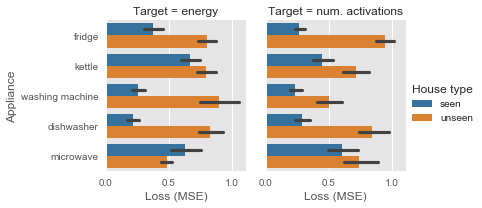

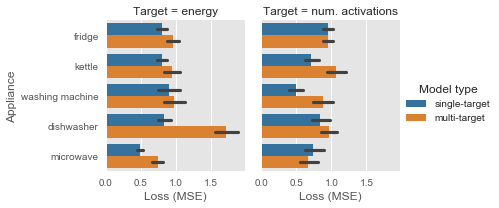

In [69]:
# Performance metrics for all apps ONLY

trans = True  # transform/standardize?
# figsize = (6,3)
size = 3  # fig height
aspect = 1  # aspect * size = fig width
saturation = 0.7
palette=np.array(sns.color_palette('tab10', 10))[[0,1]]
ci = 95  # confidence interval

trans_idx = int(trans)

# Calculate test error for seen vs. unseen.
mse_df = []
for target_type in TARGET_TYPES:
    for app_names in APP_NAMES:
        app_names = app_names_to_plot_name(app_names)
        for split_type in ['test_seen', 'test_unseen']:
            y, y_hat = preds[target_type][app_names][split_type][trans_idx]
            mse_df_this = pd.DataFrame.from_dict({'Loss (MSE)': calc_loss(y, y_hat, 'mse')[0].ravel()})
            mse_df_this['Target'] = 'energy' if target_type=='energy' else 'num. activations'
            mse_df_this['Appliance'] = app_names
            mse_df_this['House type'] = 'seen' if split_type=='test_seen' else 'unseen'
            mse_df_this['Model type'] = 'single-target'
            mse_df.append(mse_df_this)

# Calculate test error for all appliances vs. individual appliances.
for target_type in TARGET_TYPES:
    for split_type in ['test_seen', 'test_unseen']:
        y, y_hat = preds[target_type][app_names_to_plot_name(APP_NAMES)][split_type][trans_idx]
        for app_ix, app_names in enumerate(APP_NAMES):
            mse_df_this = pd.DataFrame.from_dict({'Loss (MSE)': calc_loss(y, y_hat, 'mse')[0][:,app_ix].ravel()})
            mse_df_this['Target'] = 'energy' if target_type=='energy' else 'num. activations'
            mse_df_this['Appliance'] = app_names
            mse_df_this['House type'] = 'seen' if split_type=='test_seen' else 'unseen'
            mse_df_this['Model type'] = 'multi-target'
            mse_df.append(mse_df_this)
mse_df = pd.concat(mse_df)

# Make plot for test error for seen vs. unseen.
sns.factorplot(
    x='Loss (MSE)',
    y='Appliance',
    hue='House type',
    col='Target',
    kind='bar',
    data=mse_df.loc[mse_df['Model type']=='single-target'],
    palette=palette,
    size=size,
    aspect=aspect,
    saturation=saturation,
    ci=ci
)
# fig.tight_layout()
makedirs2(dir_run)
plt.savefig(os.path.join(dir_run, 'eval_barchart_split.pdf'))
plt.show()

# Make plot for test error for all appliances vs. individual appliances.
sns.factorplot(
    x='Loss (MSE)',
    y='Appliance',
    hue='Model type',
    col='Target',
    kind='bar',
    data=mse_df.loc[(mse_df['House type']=='unseen') & (mse_df['Appliance'].isin(APP_NAMES))],
    palette=palette,
    size=size,
    aspect=aspect,
    saturation=saturation,
    ci=ci
)
# fig.tight_layout()
makedirs2(dir_run)
plt.savefig(os.path.join(dir_run, 'eval_barchart_model.pdf'))
plt.show()

In [73]:
# Print LaTeX tables of evaluation metircs.

app_names_for_latex = APP_NAMES

index_tups = []
for app_names in app_names_for_latex:
    app_names = app_names_to_plot_name(app_names)
    index_tups.append((app_names, 'seen'))
    index_tups.append((app_names, 'unseen'))
index_tups

for trans in [True, False]:
    for loss_type in ['mse', 'mae']:
        # trans = False  # transform/standardize targets?
        # loss_type = 'mae'
        
        print '\n' + '='*16
        print 'trans: {}'.format(trans)
        print 'loss_type: {}'.format(loss_type)
        print '='*16 + '\n'

        trans_idx = int(trans)

        mse_df = []
        for target_type in TARGET_TYPES:
            for app_names in app_names_for_latex:
                app_names = app_names_to_plot_name(app_names)
                for split_type in ['test_seen', 'test_unseen']:
                    y, y_hat = preds[target_type][app_names][split_type][trans_idx]
                    mse, se = calc_loss(y, y_hat, loss_type)[1:]
                    mse_df_this = pd.DataFrame.from_dict({'mse': [mse], 'se': [se]})
                    mse_df_this['Target type'] = 'Energy' if target_type=='energy' else 'Num. activations'
                    mse_df_this['Appliance'] = app_names
                    mse_df_this['House type'] = 'seen' if split_type=='test_seen' else 'unseen'
                    mse_df.append(mse_df_this)
        mse_df = pd.concat(mse_df)

        mse_df.set_index(['Appliance', 'House type'], inplace=True)

        # Calculate error plus/minus standard error.
        mse_ses = []
        num_format = '{:0.2f}' if trans else '{}'
        format_num = lambda x: x if trans else to_precision(x, 2)
        for mse, se in zip(mse_df['mse'].values, mse_df['se'].values):
            mse_se = (num_format + ' \pm ' + num_format).format(format_num(mse), format_num(2*se))
            mse_ses.append(mse_se)
        mse_df['loss'] = mse_ses
        mse_df.drop(['mse', 'se'], axis=1, inplace=True)
        # print mse_df
        
        mse_df = mse_df.pivot(columns='Target type')
        mse_df = mse_df.reindex(index_tups)

        # Convert data frame to LaTeX and make adjustments.
        mse_latex = mse_df.to_latex()
        mse_latex = mse_latex.replace('\\textbackslashpm', '$\\pm$')
        mse_latex = mse_latex.replace('\\toprule', '')
        mse_latex = mse_latex.replace('\\midrule', '\hline')
        mse_latex = mse_latex.replace('\\midrule', '\hline')
        mse_latex = mse_latex.replace('\\bottomrule', '')
        mse_latex = mse_latex.replace('\\begin{tabular}{llll}', '\\begin{tabular}{ll|cc}')
        loss_txt = 'Loss (RMSE)' if loss_type=='rmse' else 'Loss (MSE)'
        mse_latex = re.sub('\\n.*loss.*\\n', '\\n & & \\multicolumn{2}{c}{'+loss_txt+'} \\\\\\ \\n', mse_latex)  # this is hacky but it gets ride of what I want to get rid of

        print mse_latex


trans: True
loss_type: mse

\begin{tabular}{ll|cc}

 & & \multicolumn{2}{c}{Loss (MSE)} \\ 
           &      &         Energy & Num. activations \\
Appliance & House type &                &                  \\
\hline
fridge & seen &  0.37 $\pm$ 0.08 &    0.27 $\pm$ 0.04 \\
           & unseen &  0.80 $\pm$ 0.07 &    0.95 $\pm$ 0.07 \\
kettle & seen &  0.67 $\pm$ 0.08 &    0.45 $\pm$ 0.08 \\
           & unseen &  0.80 $\pm$ 0.08 &    0.71 $\pm$ 0.11 \\
washing machine & seen &  0.26 $\pm$ 0.05 &    0.23 $\pm$ 0.05 \\
           & unseen &  0.89 $\pm$ 0.16 &    0.50 $\pm$ 0.10 \\
dishwasher & seen &  0.21 $\pm$ 0.05 &    0.29 $\pm$ 0.06 \\
           & unseen &  0.83 $\pm$ 0.10 &    0.84 $\pm$ 0.13 \\
microwave & seen &  0.63 $\pm$ 0.12 &    0.61 $\pm$ 0.11 \\
           & unseen &  0.48 $\pm$ 0.05 &    0.74 $\pm$ 0.14 \\

\end{tabular}


trans: True
loss_type: mae

\begin{tabular}{ll|cc}

 & & \multicolumn{2}{c}{Loss (MSE)} \\ 
           &      &         Energy & Num. activations \\

/Users/sipola/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


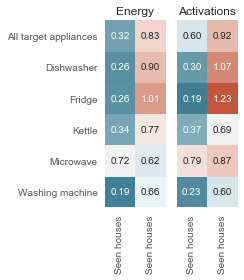

In [255]:
### Create heatmaps of performance metrics.

# sns.set_style('white')

# for split_type_idx, split_type_cols in enumerate([['All'], ['Seen houses', 'Unseen houses']]):

# house_type_idx==0 means all, while ==1 means split

# Construct performance DataFrame. Don't need to do this every 
# iteration but it's cheap anyway. Keeps the namespace a bit cleaner.
perf_df = []
for target_type in TARGET_TYPES:
    perf_this_df = pd.DataFrame.from_dict(perf[target_type], orient='index')
    perf_this_df['Target type'] = target_type
    perf_df.append(perf_this_df)
perf_df = pd.concat(perf_df)

perf_df

figsize = (3.5,4)

fig, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=figsize)
# cmap = sns.diverging_palette(10, 220, sep=80, n=7, as_cmap=True)
cols_dict = {'test_seen': 'Seen houses', 'test_unseen': 'Seen houses'}
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
vmin = perf_df[cols_dict.keys()].min().min()
vmax = perf_df[cols_dict.keys()].max().max()

perf_df.rename(columns=cols_dict, inplace=True)

# Get data for target type and plot heatmap.
for i, target_type in enumerate(TARGET_TYPES):
    perf_target = perf_df.loc[perf_df['Target type']==target_type]
    perf_target.index = map(lambda x: x.capitalize(), perf_target.index)
    perf_target.drop('Target type', axis=1, inplace=True)
    ax = axes.flat[i]
    # if house_type_idx == 0:
    #     perf_target.columns = ['']  # remove axis label "All"
    sns.heatmap(perf_target, ax=ax, annot=True, square=False, cmap=cmap,
                vmin=vmin, vmax=vmax, cbar=False, fmt='0.2f')
    ax.set_title(target_type.capitalize(), size=12)

fig.tight_layout()

# # Add title.
# plt.subplots_adjust(top=0.78 if house_type_idx==0 else 0.84)
# fig.suptitle('Test error', size=14)

# Save.
makedirs2(dir_run)
plt.savefig(os.path.join(dir_run, 'test_error_heatmap.pdf'))

plt.show()

In [32]:
def make_pred_scatter_title(target_type, app_names):
    '''Convenience function for creating plot title.'''
    title = []
    if target_type == 'energy':
        title.append('Predictions vs. actual values\nTarget type: energy use (kWh)')
    else:
        title.append('Predictions vs. actual values\nTarget type: number of activations')
    title.append('\nAppliance: {}'.format(app_names[0]))
    title = ''.join(title)
    return title

In [33]:
def get_pred_scatter_data(all_data, model, target_scaler, Y_key, app_idx, target_app_idx):
    x_house = []
    y = []
    y_hat = []
    for split_type in ['test_seen', 'test_unseen']:
        x_house = np.concatenate([x_house, all_data[split_type]['x_house']])
        y = np.concatenate([y, all_data[split_type][Y_key][:,app_idx][:,target_app_idx]])
        y_hat = np.concatenate([y_hat, target_scaler.inverse_transform(model.predict(reshape_as_tensor(all_data[split_type]['X'])))[:,target_app_idx]])
    if all(y_hat[0] == y_hat):
        warnings.warn('all predicted values are the same!')
    return x_house, y, y_hat

In [75]:
def plot_pred_scatter(
    y,
    y_hat,
    x_house,
    house_ids_seen,
    save_dir = None,
    title = None,
    lowess = False,
    fit_reg = True,
    palette = np.array(sns.color_palette('tab10', 10))[[0,1]],  # gets blue and orange from tab10 palette
    jitter = 0
):

    plt.close()
    
    x_house = map(int, x_house)
    
    max_val = max([max(y), max(y_hat)])
    # xy_line = plt.plot([0,max_val], [0,max_val], ':', color='gray')

    # Create dataset for plotting.
    plot_data = pd.DataFrame.from_dict({'Actual': y, 'Predicted': y_hat, 'House': x_house})
    plot_data['House type'] = 'unseen'
    plot_data.loc[plot_data['House'].isin(house_ids_seen), 'House type'] = 'seen'

    plot_args = {
        'x': 'Actual',
        'y': 'Predicted',
        'data': plot_data,
        'lowess': lowess,
        'truncate': True,
        'fit_reg': fit_reg,
        'x_jitter': jitter
    }
    
    g = sns.lmplot(scatter_kws={'color': 'black', 'alpha': 0.3},
                   line_kws={'color': 'black'},
                   **plot_args
    )
    lims = [-max_val*0.05,max_val*1.1]
    g.set(ylim=lims, xlim=lims)
    if title is not None:
        plt.subplots_adjust(top=0.83)
        g.fig.suptitle(title, size=14)
    if save_dir is not None:
        filename = '{}_{}_{}.pdf'.format(
            'predscatter',
            target_type,
            app_names_to_filename(app_names)
        )
        plt.savefig(os.path.join(save_dir, filename))
    # plt.show()
    plt.close()

    g = sns.lmplot(scatter_kws={'alpha': 0.3},
                   col='House',
                   hue='House type',
                   col_wrap=4,
                   size=2.3,
                   aspect=0.85,
                   palette=palette,
                   **plot_args
    )
    # plt.ylim(max_val*1.1)
    # plt.xlim(max_val*1.1)
    # g = g.map(plt.plot, [0,max_val], [0,max_val], ':', color='gray')
    g.set(ylim=lims, xlim=lims)
    if title is not None:
        plt.subplots_adjust(top=0.88)
        g.fig.suptitle(title, size=14)
    if save_dir is not None:
        filename = '{}_{}_{}.pdf'.format(
            'predscatterbyhouse',
            target_type,
            app_names_to_filename(app_names))
        plt.savefig(os.path.join(save_dir, filename))
    # plt.show()
    plt.close()

In [ ]:
# Plot scatterplots of actual vs. predicted.

modeling_group_name = 'main'

# app_names_list = [[a] for a in APP_NAMES] + [APP_NAMES]
app_names_list = [[a] for a in APP_NAMES]
target_app_idx = 2

for target_type in TARGET_TYPES:
    print target_type
    Y_key = 'Y1' if target_type=='energy' else 'Y2'
    for app_names in app_names_list:
        
        app_names_pretty = app_names_to_plot_name(app_names)
        print '    {}'.format(app_names_pretty)
        
        app_idx = [APP_NAMES.index(app_name) for app_name in app_names]
        
        # Get model objects.
        dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
        model_name = get_best_model_name(dir_models_set)
        model = load_best_model(dir_models_set)
        target_scaler = pickle.load(open(os.path.join(dir_models_set, model_name, 'target_scaler.pkl'), 'rb'))
        
        if len(app_idx) == 1:
            target_app_idx = 0
        
        # Get actual and predictions.
        x_house, y, y_hat = get_pred_scatter_data(all_data, model, target_scaler, Y_key, app_idx, target_app_idx)
        
        # title = make_pred_scatter_title(target_type, app_names)
        title = None
        # print '        starting plot...'
        pred_scatter_dir = os.path.join(dir_run, 'predscatter')
        makedirs2(pred_scatter_dir)
        plot_pred_scatter(
            y = y,
            y_hat = y_hat,
            x_house = x_house,
            house_ids_seen = HOUSE_IDS_SEEN,
            save_dir = pred_scatter_dir,
            # palette = palette,
            title = title,
            # lowess = True,
            jitter = 0.2 if target_type=='activations' else 0
        )

energy
    fridge


In [63]:
modeling_group_name = 'main'
target_type = 'activations'
app_names = ['kettle']
# app_names = APP_NAMES

dir_models_set = os.path.join(dir_models, modeling_group_name, target_type, app_names_to_filename(app_names))
hist_and_params = get_histories_df(dir_models_set)
# hist_and_params

In [64]:
# model_name = get_best_model_name(dir_models_set)
# model = load_best_model(dir_models_set)
# target_scaler = pickle.load(open(os.path.join(dir_models_set, model_name, 'target_scaler.pkl'), 'rb'))

In [65]:
hist_and_params[[
    'epoch',
    'val_loss',
    'runtime',
    'num_conv_layers',
    'num_dense_layers',
    'start_filters',
    'kernel_size',
    'strides',
    'pool_size',
    'last_dense_layer_size',
    'learning_rate',
    'l2_penalty'
]]

,epoch,val_loss,runtime,num_conv_layers,num_dense_layers,start_filters,kernel_size,strides,pool_size,last_dense_layer_size,learning_rate,l2_penalty
model,,,,,,,,,,,,
model_6,15,0.579830,41.879612,6,2,4,6,1,4,9,0.00235498,2.66084e-07
model_5,15,0.627106,40.901056,6,1,4,6,1,4,10,0.00204722,1.20382e-07
model_11,9,0.712767,146.498831,7,2,4,3,1,2,15,0.00111021,9.93927e-07
model_10,19,0.740828,274.493657,8,1,4,4,1,2,12,0.000612574,8.87213e-07
model_13,7,0.828408,35.611423,4,1,8,3,2,2,12,0.00147552,0
model_7,10,0.835410,55.830662,4,1,6,4,1,3,17,0.00155307,0
model_14,5,0.858916,inf,5,1,6,3,2,3,9,0.00122891,5.37501e-07
model_1,9,0.865417,17.725850,4,2,4,3,2,2,23,0.00207468,2.51357e-07
model_2,17,0.866670,35.386390,6,1,7,5,2,2,30,0.000303061,0


In [263]:
row = 12

data_set = 'test'

Y_key = 'Y1' if target_type=='energy' else 'Y2'

series = all_data[data_set]['X'][row]
house_id = all_data[data_set]['x_house'][row]
dt = all_data[data_set]['x_date'][row]
activations = get_activations(series, model_truncated)

print all_data[data_set][Y_key][row]
print target_scaler.inverse_transform(get_activations(series, model))
print 'activations.shape: {}'.format(activations.shape)

print model_truncated.summary()

# ax.get_yaxis().set_visible(False)

[18  1  4  1  0]
[ 3.04652143]
activations.shape: (80, 178)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv1D)              (None, 14400, 5)          50        
_________________________________________________________________
pool_0 (MaxPooling1D)        (None, 4800, 5)           0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 4800, 10)          460       
_________________________________________________________________
pool_1 (MaxPooling1D)        (None, 1600, 10)          0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 1600, 20)          1820      
_________________________________________________________________
pool_2 (MaxPooling1D)        (None, 534, 20)           0         
_________________________________________________________________
conv_3 (Conv1D) 

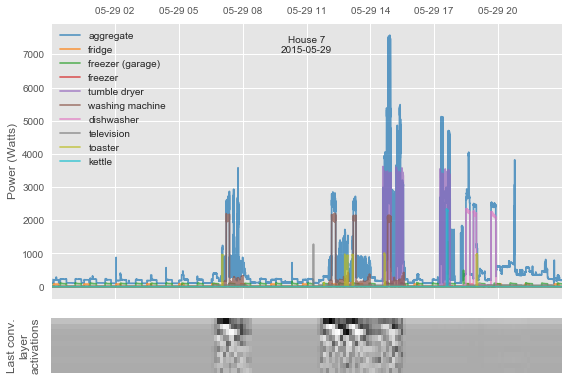

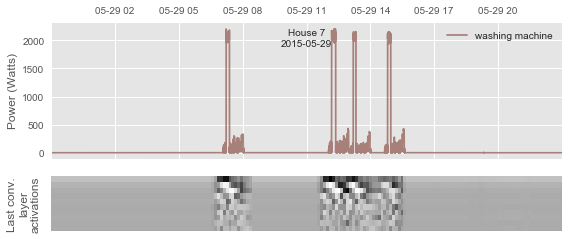

In [376]:
# row 10 of test (house 7, 2015-05-29) for good washing machine and dishwasher activations.

k = 10
# activations_pca = activations[np.random.choice(activations.shape[0], k, replace=False)]
activations_pca = PCA(k).fit_transform(activations.T).T
activations_pca = activations_pca - activations_pca.min()  # scale so min is zero

plot_series_activations(house_id, date_to_datetime(dt), activations_pca)
plot_series_activations(house_id, date_to_datetime(dt), activations_pca,
                        apps_to_plot=get_standardized_app_names(house_id, app_names[0]),
                        figsize=(8,3.5), height_ratios=[5, 2])

In [295]:
# app_idx2 = 2
# app_idx2 = list(app_idx)
target_app_idx = 2
if len(app_idx) == 1:
    target_app_idx = 0
y_val = all_data['test'][Y_key][:,app_idx][:,target_app_idx]
y_hat = target_scaler.inverse_transform(model.predict(reshape_as_tensor(all_data['test']['X'])))[:,target_app_idx]
if all(y_hat[0] == y_hat):
    print 'all predicted values are the same!'

NameError: name 'app_idx' is not defined

In [265]:
# # sns.distplot(np.log2(y+1))
# # sns.distplot(y, color='black')

# value_to_plot = y_val

# plot_empir_cum(value_to_plot)
# plt.show()
# sns.distplot(value_to_plot, color='black', hist_kws={'cumulative': True}, kde_kws={'cumulative': True})
# plt.show()
# sns.distplot(value_to_plot, color='black')
# plt.show()

# # for i in range(Y.shape[1]):
# #     ax = sns.distplot(Y[:,i], color='black')
# #     ax.set_title('{}, actual'.format(APP_NAMES[i]))
# #     plt.show()
# #     ax = sns.distplot(Y_hat[:,i], color='black')
# #     ax.set_title('{}, predicted'.format(APP_NAMES[i]))
# #     plt.show()

In [ ]:
split_key = 'test'
target_app_idx = 2
if len(app_idx) == 1:
    target_app_idx = 0
y = all_data[split_key][Y_key][:,app_idx][:,target_app_idx]
print 'getting prediction data...'
y_hat = target_scaler.inverse_transform(model.predict(reshape_as_tensor(all_data[split_key]['X'])))[:,target_app_idx]
x_house = all_data[split_key]['x_house']

In [43]:
all_data.keys()

['val', 'synth_train_all', 'test_seen', 'test_unseen', 'real_train']

creating data for plot...

creating plot...
saving plot...


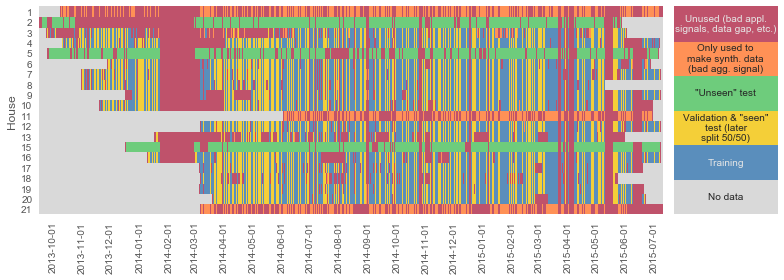

In [187]:
# Plot data split and quality heatmap.
print 'creating data for plot...'

style = 'landscape'

if style=='landscape':
    figsize=(11,4)
else:
    figsize=(4,10)

dstats2 = dstats.copy()
dstats2 = dstats2[['House', 'Delete', 'Delete_BadAgg']]
dstats2.reset_index(inplace=True)
dstats2.columns = dstats2.columns.droplevel(1)

split_df = []
for split_type, type_id in {'real_train': 1, 'val': 2, 'test_seen': 2, 'test_unseen': 3}.iteritems():
    split_info = pd.DataFrame({
        'House': all_data[split_type]['x_house'],
        'Time': np.array(all_data[split_type]['x_date'], dtype=np.datetime64),
        'Type': type_id
    })
    split_df.append(split_info)
split_df = pd.concat(split_df)
dstats2 = pd.merge(dstats2, split_df, how='left', on=['House', 'Time'])

# Sort out solar business. Take into account fact that solar was simply
# removed earlier instead of setting Delete_BadAgg==1
dstats2.loc[dstats2['House'].isin(HOUSE_IDS_SOLAR), 'Delete_BadAgg'] = 1
# dstats2.loc[dstats2['House'].isin(HOUSE_IDS_SOLAR), 'Type'] = 1

# print set(dstats.loc[(dstats['Delete_BadAgg']==1) & (dstats['Delete']!=1), 'House'].values)

# print dstats2.loc[dstats2['House'].isin(HOUSE_IDS_NOT_SOLAR)].head()
# print dstats2.loc[dstats2['House'].isin(HOUSE_IDS_NOT_SOLAR)].tail()

dstats2.loc[(dstats2['Delete_BadAgg']==1) & \
            (dstats2['House'].isin(HOUSE_IDS_NOT_TEST_UNSEEN)) & \
            (dstats2['Time'].isin(train_dates)), 'Type'] = 4  # since bad aggs are not found in data sets

dstats2.loc[(dstats2['Delete_BadAgg']==1) & (dstats2['Type']==1), 'Type'] = 4  # only used in synthetic data
# print dstats2.loc[(dstats2['Delete_BadAgg']==1) & ~(dstats2['Type']==4) & (dstats2['Delete']==0)]
dstats2.loc[(dstats2['Delete_BadAgg']==1) & ~(dstats2['Type']==4), 'Type'] = 5  # ideally would've included these in synth creation but it was difficult to implement
dstats2.loc[dstats2['Delete']==1, 'Type'] = 5

dstats2['Date'] = map(lambda x: x, dstats2['Time'])
dstats2 = dstats2.pivot(index='Date', columns='House', values='Type')  # cast for heatmap
dstats2[pd.isnull(dstats2)] = 0  # get rid of nulls (heatmaps doesn't like them)

# Construct cmap.
colors = [
    '#5A8EBC',  # blue
    '#F4CF38',  # yellow
    '#6ECC7C',  # green
    '#FF9156',  # orange
    '#BF526B'   # red
]  # https://coolors.co/5a8ebc-6ecc7c-ff9156-f4cf38-bf526b
colors = [[.85, .85, .85]] + colors
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

fig = plt.figure(figsize=figsize)
if style=='landscape':
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[6, 1])
else:
    gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[9, 1])
ax = plt.subplot(gs[0])
cax = plt.subplot(gs[1])

labels = [
    'No data',
    'Training',
    'Validation & "seen"\ntest (later\nsplit 50/50)',
    '"Unseen" test',
    'Only used to\nmake synth. data\n(bad agg. signal)',
    'Unused (bad appl.\nsignals, data gap, etc.)'
]

cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap)
cbar.ax.set_yticklabels(''*len(labels))  # vertically oriented colorbar
cbar.outline.set_visible(False)

# https://stackoverflow.com/a/15913419/4794432
for j, lab in enumerate(labels):
    color = '0.9' if j in [1,5] else '0.15'
    cbar.ax.text(.5, (2 * j + 1) / 12.0, lab, ha='center', va='center', color=color)  # for 6 colors

# Make date ticks pretty.
ticklabels = [dt64_to_datetime(d).date() if dt64_to_datetime(d).day==1 else '' for d in dstats2.index.values]

print 'creating plot...'
if style=='landscape':
    args = {'xticklabels': ticklabels}
    dstats2 = dstats2.T
else:
    args = {'yticklabels': ticklabels}
    
sns.heatmap(dstats2,
            cmap=my_cmap,
            ax=ax,
            cbar=False,
            **args)

# ax.set_title('Data split and data quality', size=14)
if style=='landscape':
    ax.set_xlabel('')
else:
    ax.set_ylabel('')

fig.tight_layout()

makedirs2(dir_run)
print 'saving plot...'
plt.savefig(os.path.join(dir_run, 'data_split_and_quality.pdf'))

creating data for plot...
creating plot...
saving plot...


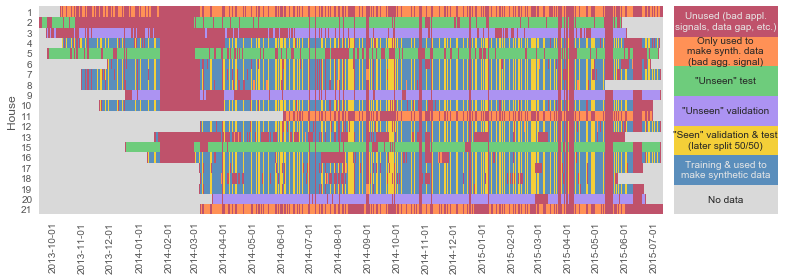

In [10]:
# Plot data split and quality heatmap.
print 'creating data for plot...'

style = 'landscape'

if style=='landscape':
    figsize=(11,4)
else:
    figsize=(4,10)

dstats2 = dstats.copy()
dstats2 = dstats2[['House', 'Delete', 'Delete_BadAgg']]
dstats2.reset_index(inplace=True)
dstats2.columns = dstats2.columns.droplevel(1)

split_df = []
for split_type, type_id in {
    'real_train': 1,
    'val_seen': 2,
    'val_unseen': 3,
    'test_seen': 2,
    'test_unseen': 4
}.iteritems():
    split_info = pd.DataFrame({
        'House': all_data[split_type]['x_house'],
        'Time': np.array(all_data[split_type]['x_date'], dtype=np.datetime64),
        'Type': type_id
    })
    split_df.append(split_info)
split_df = pd.concat(split_df)
dstats2 = pd.merge(dstats2, split_df, how='left', on=['House', 'Time'])

# Sort out solar business. Take into account fact that solar was simply
# removed earlier instead of setting Delete_BadAgg==1
dstats2.loc[dstats2['House'].isin(HOUSE_IDS_SOLAR), 'Delete_BadAgg'] = 1
# dstats2.loc[dstats2['House'].isin(HOUSE_IDS_SOLAR), 'Type'] = 1

dstats2.loc[(dstats2['Delete_BadAgg']==1) & \
            (dstats2['House'].isin(HOUSE_IDS_SEEN)) & \
            (dstats2['Time'].isin(train_dates)), 'Type'] = 5  # since bad aggs are not found in data sets

dstats2.loc[(dstats2['Delete_BadAgg']==1) & (dstats2['Type']==1), 'Type'] = 5  # only used in synthetic data
# print dstats2.loc[(dstats2['Delete_BadAgg']==1) & ~(dstats2['Type']==4) & (dstats2['Delete']==0)]
dstats2.loc[(dstats2['Delete_BadAgg']==1) & ~(dstats2['Type']==5), 'Type'] = 6  # ideally would've included these in synth creation but it was difficult to implement
dstats2.loc[dstats2['Delete']==1, 'Type'] = 6

dstats2['Date'] = map(lambda x: x, dstats2['Time'])
dstats2 = dstats2.pivot(index='Date', columns='House', values='Type')  # cast for heatmap
dstats2[pd.isnull(dstats2)] = 0  # get rid of nulls (heatmaps doesn't like them)

# Construct cmap.
colors = [
    '#5A8EBC',  # blue
    '#F4CF38',  # yellow
    '#AC93F2',  # purple
    '#6ECC7C',  # green
    '#FF9156',  # orange
    '#BF526B'   # red
]  # https://coolors.co/5a8ebc-6ecc7c-ff9156-f4cf38-bf526b
colors = [[.85, .85, .85]] + colors
my_cmap = ListedColormap(sns.color_palette(colors).as_hex())

fig = plt.figure(figsize=figsize)
if style=='landscape':
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[6, 1])
else:
    gs = matplotlib.gridspec.GridSpec(2, 1, height_ratios=[9, 1])
ax = plt.subplot(gs[0])
cax = plt.subplot(gs[1])

labels = [
    'No data',
    'Training & used to\nmake synthetic data',
    '"Seen" validation & test\n(later split 50/50)',
    '"Unseen" validation',
    '"Unseen" test',
    'Only used to\nmake synth. data\n(bad agg. signal)',
    'Unused (bad appl.\nsignals, data gap, etc.)'
]

cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap)
cbar.ax.set_yticklabels(''*len(labels))  # vertically oriented colorbar
cbar.outline.set_visible(False)

# https://stackoverflow.com/a/15913419/4794432
for j, lab in enumerate(labels):
    color = '0.9' if j in [1,6] else '0.15'
    cbar.ax.text(.5, (2 * j + 1) / 14, lab, ha='center', va='center', color=color)  # for 6 colors

# Make date ticks pretty.
ticklabels = [dt64_to_datetime(d).date() if dt64_to_datetime(d).day==1 else '' for d in dstats2.index.values]

print 'creating plot...'
if style=='landscape':
    args = {'xticklabels': ticklabels}
    dstats2 = dstats2.T
else:
    args = {'yticklabels': ticklabels}
    
sns.heatmap(dstats2,
            cmap=my_cmap,
            ax=ax,
            cbar=False,
            **args)

# ax.set_title('Data split and data quality', size=14)
if style=='landscape':
    ax.set_xlabel('')
else:
    ax.set_ylabel('')

fig.tight_layout()

makedirs2(dir_run)
print 'saving plot...'
plt.savefig(os.path.join(dir_run, 'data_split_and_quality.pdf'))

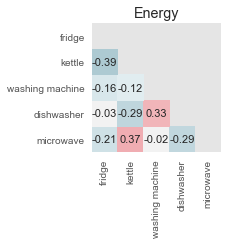

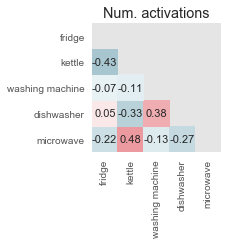

In [466]:
# Compute correlations between target variables.

def create_target_heatmap(Y, names, title='', figsize=(3.5,3.5),
                          linewidths=0, annot=True, fmt='.2f'):

    # http://seaborn.pydata.org/examples/many_pairwise_correlations.html

    # Compute the correlation matrix.
    Y_df = pd.DataFrame(Y)
    Y_df.columns = APP_NAMES
    corr = Y_df.corr()

    # Generate a mask for the upper triangle.
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure.
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap.
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio.
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, annot_kws={"fontsize":11}, fmt=fmt,
                annot=annot, square=True, linewidths=linewidths, ax=ax, cbar=False)
    ax.set_title(title)
    
    return f, ax

split_type = 'real_train'
makedirs2(dir_run)
create_target_heatmap(all_data[split_type]['Y1'], APP_NAMES, title='Energy')
plt.tight_layout()
plt.savefig(os.path.join(dir_run, 'corr_app_energy.pdf'))
create_target_heatmap(all_data[split_type]['Y2'], APP_NAMES, title='Num. activations')
plt.tight_layout()
plt.savefig(os.path.join(dir_run, 'corr_app_activations.pdf'))

In [26]:
tmp = map(str, range(cm.shape[0]))
tmp[-1] = tmp[-1] + '+'
tmp

confusion_matrix(np.around(y), np.around(y_hat), labels=True)

TypeError: iteration over a 0-d array

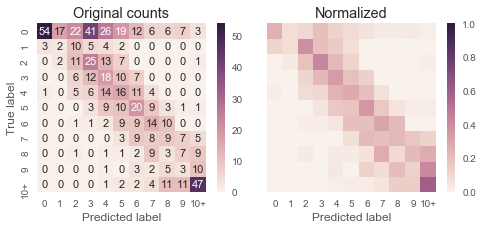

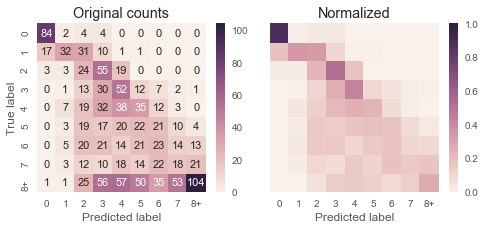

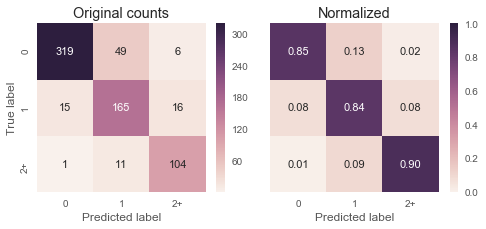

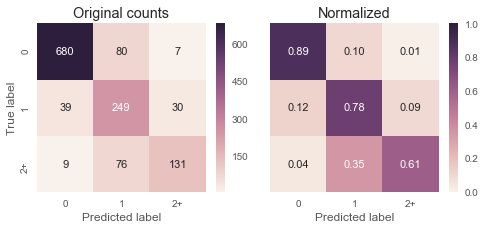

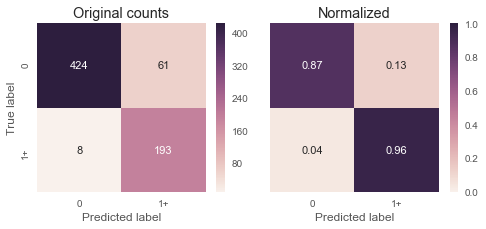

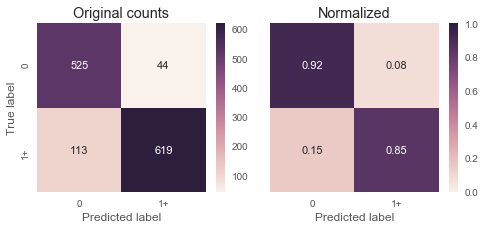

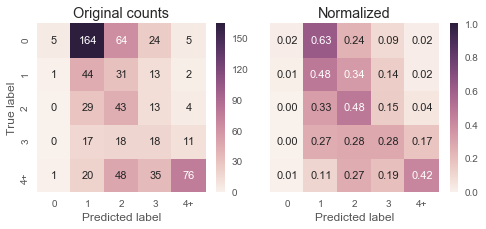

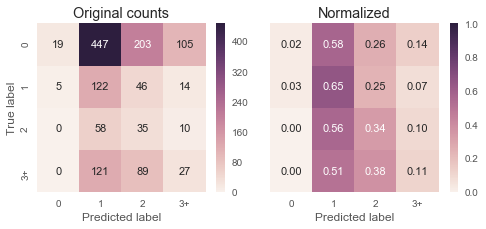

In [61]:
# Plot confusion matrix by using seaborn heatmap function
def plot_confusion_matrix(cm, normalize=False, classes=None, title='', ticklabels=None, annot=True):
    """
    Credit: Data Mining and Exploration (DME) course at University of Edinburgh
    https://github.com/agamemnonc/dme/blob/master/04_Lab_4_Performance_evaluation_model_selection_solution.ipynb
    
    Plots a confusion matrix.
    
    If normalize is set to True, the rows of the confusion matrix are normalized so that they sum up to 1.
    
    """
    if normalize is True:
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        vmin, vmax = 0., 1.
        fmt = '.2f'
    else:
        vmin, vmax = None, None
        fmt = 'd'
        
    if ticklabels is None:
        ticklabels = map(str, range(cm.shape[0]))
        ticklabels[-1] = ticklabels[-1] + '+'    
    
    sns.heatmap(cm, annot=annot, fmt=fmt, annot_kws={"fontsize":11}, vmin=vmin, vmax=vmax,
               xticklabels = ticklabels, yticklabels = ticklabels, square=True)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


for target_type in ['activations']:
    for app_name in APP_NAMES[1:]:  # no fridge
        for split_type in ['test_seen', 'test_unseen']:
            
            y, y_hat = preds[target_type][app_name][split_type][0]  # 0 index = original units
            y_max = max([np.percentile(y, 98), np.percentile(y_hat, 98)])
            y[y > y_max] = y_max
            y_hat[y_hat > y_max] = y_max

            cm = confusion_matrix(np.around(y), np.around(y_hat), labels=range(int(np.ceil(y_max))+1))
            # print cm
            
            fig = plt.figure(figsize=(7,3))
            ax1 = fig.add_subplot(121)
            plot_confusion_matrix(cm, normalize=False, title='Original counts') # un-normalized
            ax2 = fig.add_subplot(122)
            plot_confusion_matrix(cm, normalize=True, title='Normalized',
                                 annot=app_name != 'kettle')  # normalized
            ax2.get_yaxis().set_visible(False)
            fig.tight_layout()
            
            cm_dir = os.path.join(dir_run, 'cm')
            makedirs2(cm_dir)
            plt.savefig(os.path.join(cm_dir, 'confusion_matrix_{}_{}_{}.pdf'.format(target_type, app_names_to_filename(app_name), split_type)))
            


In [ ]:
# "How convolutional neural networks see the world":
#     https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
# 

model.get_layer('conv_2')

In [ ]:
# Check where targets were normal but predictions were extreme.
extreme_y_hat_cutoff = 10

bad_idx = np.where(y_hat > extreme_y_hat_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 0  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [ ]:
# Check where targets were extreme but predictions were too low.
extreme_y_cutoff = 2

bad_idx = np.where(y_val > extreme_y_cutoff)[0]
print 'num extreme predictions: {}'.format(len(bad_idx))

i = 1  # change this
print 'extreme prediction {}'.format(i)

house_id = val_data[x_house_idx][bad_idx][i]
d = val_data[x_date_idx][bad_idx][i]
energy = val_data[Y_idx][:,app_idx][bad_idx][i]
print 'actual energy: {}, predicted: {}'.format(energy, y_hat[bad_idx][i])

plot_day(house_id, date_to_datetime(d), figsize=(15,8))

In [ ]:
# val_data[X_idx][0]
i = 21
app_name = 'washing machine'

app_idx = APP_NAMES.index(app_name)

plot_series(val_data[X_idx][i])
house_id = val_data[x_house_idx][i]
d = val_data[x_date_idx][i]
energy1 = val_data[Y_idx][i][app_idx]
print house_id, d, energy1

plot_day(house_id, date_to_datetime(d))
energy2 = get_energy(dstats, house_id, d, get_app_nums(house_id, app_name))
print energy2